In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data=pd.read_csv('Customers_in_a_Shop.csv', header=None)
data.head()

,0,1
0,1949-01,114.0
1,1949-02,120.0
2,1949-03,134.0
3,1949-04,67.0
4,1949-05,123.0


In [3]:
data.columns=['date', 'value']
data['date']= pd.to_datetime(data['date'], format='%Y-%m')
data=data.set_index('date')

In [4]:
data.head()

,value
date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0


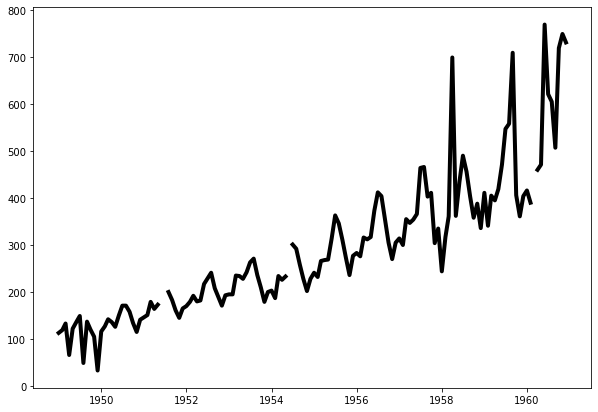

In [5]:
plt.figure(figsize=[10,7])
plt.plot(data.value, color='black',linewidth=4)

In [6]:
data['value'].interpolate(method='linear', inplace=True)

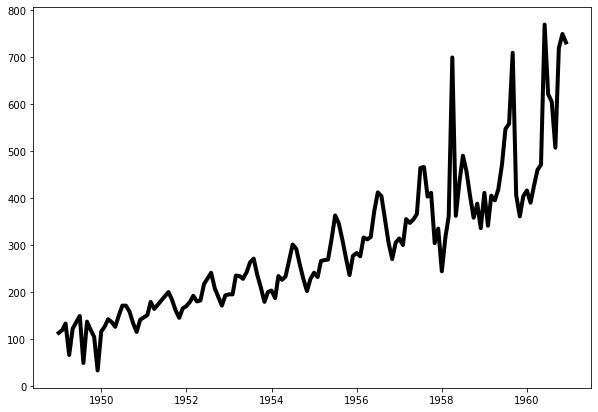

In [7]:
plt.figure(figsize=[10,7])
plt.plot(data.value, color='black',linewidth=4)

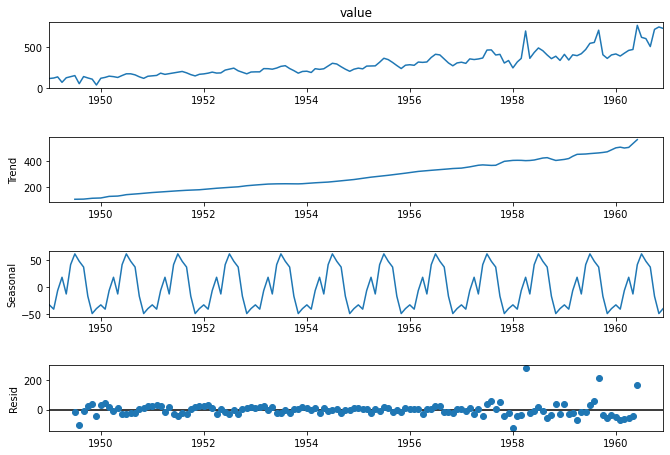

In [8]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
res= seasonal_decompose(data.value, model='additive', period=12)
fi=res.plot()
fi.set_size_inches((10,7))
fi.show()

In [9]:
from scipy.stats import boxcox
data_t=boxcox(data.value, lmbda=0.0)
data_t=pd.Series(data_t, index=data.index)
data_t.head()

date
1949-01-01    4.736198
1949-02-01    4.787492
1949-03-01    4.897840
1949-04-01    4.204693
1949-05-01    4.812184
dtype: float64

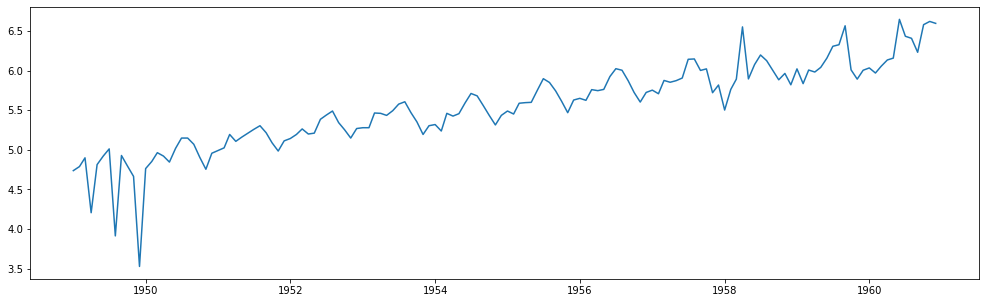

In [10]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data_t)

### Diffferencing
 stabilize mean by changing level in series and therefore eliminating (or reducing) trend and seasonality

In [11]:
data_td=pd.Series(data.value-data.value.shift(),index= data.index)
data_td.head()

date
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01   -67.0
1949-05-01    56.0
Name: value, dtype: float64

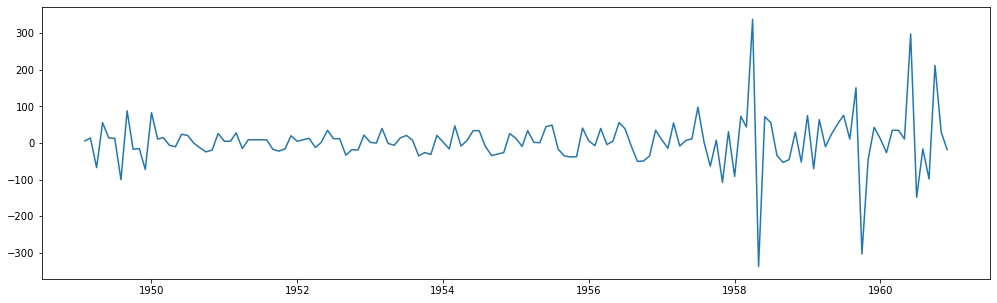

In [12]:
data_td.dropna(inplace = True)
plt.plot(data_td)

In [13]:
from statsmodels.tsa.stattools import kpss, adfuller

In [14]:
ad_test=adfuller(data_td)
print('ADF statatics: ',ad_test[0])
print('p-value: ',ad_test[1])
for key, value in ad_test[4].items():
    print(key, value)

ADF statatics:  -5.455532535469498
p-value:  2.5868321718299994e-06
1% -3.482087964046026
5% -2.8842185101614626
10% -2.578864381347275


In [15]:
kpss_test= kpss(data_td)
print('kpss statatics: ',kpss_test[0])
print('p-value: ',kpss_test[1])
for key, value in kpss_test[3].items():
    print(key, value)

kpss statatics:  0.2440409658687194
p-value:  0.1
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


C:\Users\Varun Salunkhe\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Autocorelation fuctiona

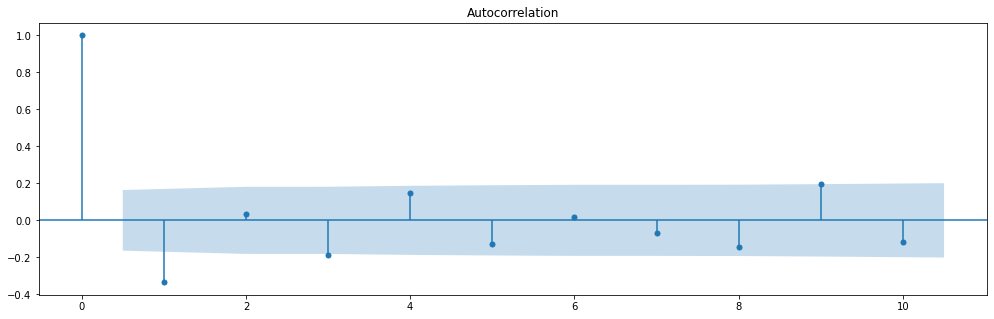

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_td, ax= plt.gca(), lags=10)
plt.show()

### Partial auto corelation function

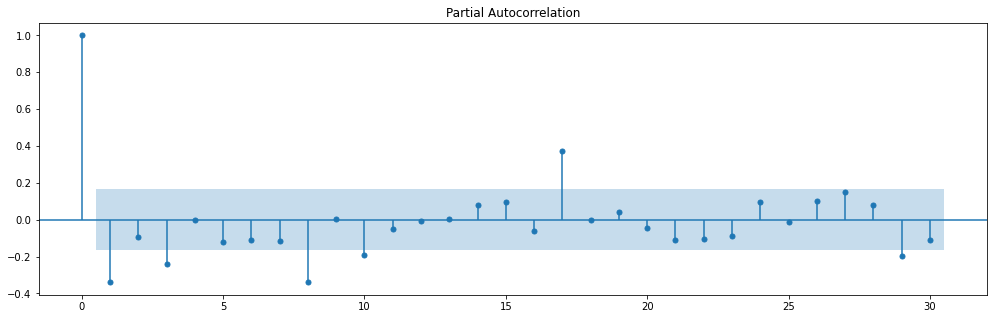

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_td, ax= plt.gca(), lags=30)
plt.show()

In [18]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,: ]

train_data_boxcox = data_t[:length_train]
test_data_boxcox = data_t[length_train:]

train_data_boxcox_difference = data_td[:length_train-1]
test_data_boxcox_difference = data_td[length_train-1:]

In [19]:
data_t[0]

4.736198448394496

In [20]:
from statsmodels.tsa.arima_model import ARIMA
model1=ARIMA(train_data_boxcox_difference , order=(1,0,0))
model1_fit=model1.fit()
model1_fit.params

C:\Users\Varun Salunkhe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const          3.174688
ar.L1.value   -0.371941
dtype: float64

In [21]:
copy_data1= data_td.copy()
copy_data1['forcast_datatd']= model1_fit.predict(data_td.index.min(),data_td.index.max())
copy_data1['forcast_datat']=copy_data1['forcast_datatd'].cumsum()
copy_data1['forcast_datat']=copy_data1['forcast_datat'].add(data_t[0])
copy_data1['forcast']=np.exp(copy_data1['forcast_datat'])

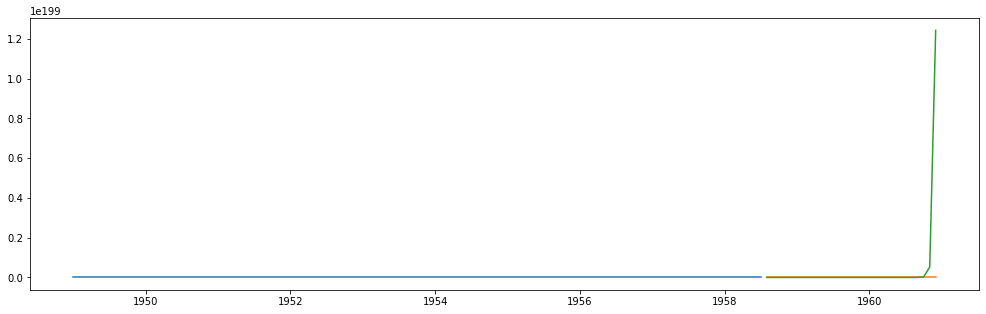

In [22]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(copy_data1['forcast'][test.index.min():], label = 'AR model')